In [1]:
#Importing various libraries and modules

import re
import os
import string
import inflect
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np
import pyLDAvis
import seaborn as sns
import warnings

# Ignore FutureWarning and UserWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
nltk.download('stopwords')
nltk.download('punkt')



[nltk_data] Downloading package stopwords to
[nltk_data]     /usr4/ds549/saisurya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /usr4/ds549/saisurya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Q2.2 Pre-Processing

In [2]:
def read_files_from_directory(directory_path):
    """Read .md files from a directory."""
    contents = []
    filenames = []

    for filename in os.listdir(directory_path):
        if filename.endswith('.md'):
            with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
                contents.append(file.read())
                filenames.append(filename)

    return contents, filenames

# Get content and names of .md files from a directory
readmes, filenames = read_files_from_directory('/projectnb/ds549/students/saisurya/ml-549-course/homeworks/fall23_hw1/datasets/readmes')


In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
p = inflect.engine()


def clean_text(text):
    # Removing emojis
    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # Removing user mentions
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'!\[.*?\]\(.*?\)', '', text)  # For images
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)   # For inline links
    
    # Removing hashtags
    text = re.sub(r'#\w+', '', text)

    # Removing URLs
    text = re.sub(r'https?://\S+', '', text)    
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    #Convert to lowercase and remove some common words
    text = re.sub(r'\b(Code of Conduct|Community|Contributing|Documentation|Features|Getting Started|License|Roadmap|Architecture|Installation|Example|Using|Configuration|Config|Conduct|How|Reporting|Building|Authentication|Quick|Release|Demo|Support|Contact|Running|Usage|Get|Overview|Develop|support|Start|&|Prerequisites|image|Meeting|Status|Build|using|Why|Create|use|Releases|start|Project|Installing|Meetings|)\b', "", text)
    text  = text.lower()
    text = re.sub(r'\b(project|see|service|version|please|file|release|application|run|policy|resource|yes)\b', "", text)
    # Tokenizing
    words = word_tokenize(text)
    
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Filtering words
    cleaned_words = [word for word in words if word.isalpha() and word not in stop_words and word not in string.punctuation]

    return ' '.join(cleaned_words)

cleaned_readmes = [clean_text(readme) for readme in readmes]



In [4]:


# Set up CountVectorizer with max document frequency
vectorizer = CountVectorizer(max_df=30)

# Transform cleaned readmes using CountVectorizer
X = vectorizer.fit_transform(cleaned_readmes)

# Initialize TF-IDF transformer
transformer = TfidfTransformer()

# Convert the count matrix to a normalized tf-idf representation
tfidf = transformer.fit_transform(X)



## Q2.3 Training and Evaluation

In [5]:
# Choosing the number of topics for LDA
n_topics = 3
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(tfidf)

# Display the top words for each topic for interpretation
def display_topics(model, feature_names, no_top_words=20):
    """Display top words for each topic and return topic labels."""
    topics_names = [
        "Kubernetes Tooling and Extensions",
        "Service Mesh and Kubernetes Management",
        "Monitoring, Tracing, and Advanced Configuration"
    ]

    topics_labels = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics_labels[topics_names[topic_idx]] = ", ".join(top_words)
        print(f"{topics_names[topic_idx]}: {', '.join(top_words)}")
    
    return topics_labels

feature_names = vectorizer.get_feature_names_out()
topic_labels = display_topics(lda, feature_names)

# Assign the most dominant topic to each repository based on its content
repository_topics = {}
for idx, repo in enumerate(cleaned_readmes):
    topic_distribution = lda.transform(vectorizer.transform([repo]))
    dominant_topic = topic_distribution[0].argmax()
    repository_name = filenames[idx]
    repository_topics[repository_name] = list(topic_labels.keys())[dominant_topic]


Kubernetes Tooling and Extensions: helm, chart, specification, cni, app, falco, keptn, antrea, zot, kepler, strimzi, kuberhealthy, coredns, kubescape, plugins, dapr, spiffe, openmetrics, devstream, ko
Service Mesh and Kubernetes Management: istio, edge, mesh, branch, kubectl, opa, function, proxy, harbor, plane, linux, registry, volume, traffic, karmada, spire, longhorn, openebs, controller, keycloak
Monitoring, Tracing, and Advanced Configuration: nbsp, chaos, opentelemetry, sdk, etcd, instrumentation, jaeger, grpc, mesh, kyverno, bfe, provider, stability, linkerd, schemahero, experimental, pixie, keda, akri, branch


In [6]:
# Group filenames by their dominant topics
topics_grouped_by_files = {}
for filename, topic in repository_topics.items():
    if topic not in topics_grouped_by_files:
        topics_grouped_by_files[topic] = []
    topics_grouped_by_files[topic].append(filename)

# Write to the 'hw1_output.txt' file
with open('hw1_output.txt', 'w') as output_file:
    for topic, associated_files in topics_grouped_by_files.items():
        # Write the topic name
        output_file.write(f"**{topic}**:\n")
        
        # Write each filename associated with the topic
        for filename in associated_files:
            output_file.write(f"    {filename}\n")
        output_file.write("\n")  




## Visualization and Analysis:

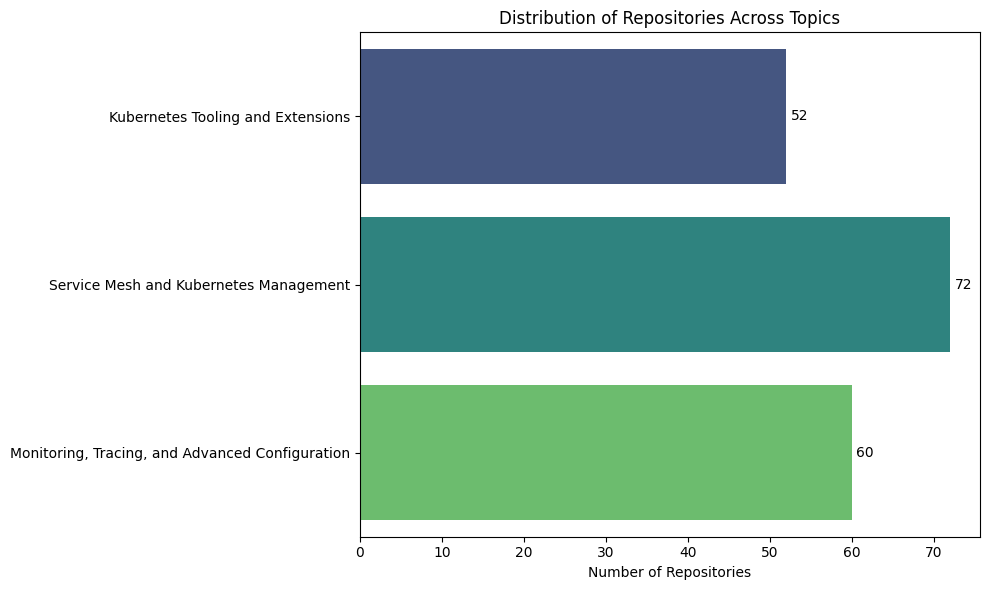

In [7]:
# Count repositories per topic
topic_counts = {label: 0 for label in topic_labels.keys()}  # Use custom topic names
for topic in repository_topics.values():
    topic_counts[topic] += 1

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(topic_counts.values()), y=list(topic_counts.keys()), palette='viridis', orient='h')

# Adding count numbers to the bars
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.5, p.get_y() + p.get_height()/2, '{:1.0f}'.format(width), ha="left", va="center")

plt.xlabel('Number of Repositories')
plt.title('Distribution of Repositories Across Topics')
plt.tight_layout()
plt.show()


In [8]:
import pyLDAvis

def prepare_lda_visualization(model, document_term_matrix, vec):

    #Prepare LDA data for visualization using pyLDAvis.
    #model: Trained LDA model.
    #document_term_matrix: Matrix representation of documents.
    #vec: Vectorizer used to transform the documents.
    
    # Calculate topic-term distributions
    topic_term_distribution = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

    # Calculate document-topic distributions
    doc_topic_distribution = model.transform(document_term_matrix)

    # Retrieve terms/feature names from the vectorizer
    terms = vec.get_feature_names_out()

    # Prepare data for pyLDAvis
    visualization_data = pyLDAvis.prepare(
        topic_term_dists=topic_term_distribution,
        doc_topic_dists=doc_topic_distribution,
        doc_lengths=document_term_matrix.sum(axis=1).getA1(),
        vocab=terms,
        term_frequency=document_term_matrix.sum(axis=0).getA1(),
        sort_topics=False
    )
    
    return visualization_data

# Prepare LDA visualization data
visualization_data = prepare_lda_visualization(lda, X, vectorizer)

# Display the visualization in the notebook
pyLDAvis.display(visualization_data)


## Steps and Analysis:

**Data Collection and Reading:**

I read the contents of Markdown files (.md) from the 'fall23_hw1/datasets/readmes' directory.

**Data Preprocessing:**

Removed emojis, user mentions, images, inline links, hashtags, URLs, and specific words.
Lowercased and tokenized the text, and removed stopwords.
Words were lemmatized.

**Feature Engineering:**

Transformed the preprocessed text into a document-term matrix (DTM) using CountVectorizer. Parameters like max_df were employed to eliminate high-frequency terms.
Used TfidfTransformer to weight terms based on their importance.

**Topic Modeling with LDA:**

Initialized the LDA model with 3 topics.
Trained the LDA model on the TF-IDF matrix.

**Topic Interpretation:**

Displayed top 20 terms for each topic.
Assigned custom names based on the top words:
Kubernetes Tooling and Extensions (52 repositories)
Service Mesh and Kubernetes Management (72 repositories)
Monitoring, Tracing, and Advanced Configuration (60 repositories)

**Document-Topic Assignment:**

Assigned a dominant topic to each repository based on content.

**Output Generation:**

Created a text file named 'hw1_output.txt', which contains the topic names, and under each topic, the respective filenames of repositories are listed.

**Visualization and Analysis:**

Visualized topics using pyLDAvis.
Created a bar plot showing repository distribution across topics.

**Analysis:**

I initially tried 5 topics but later narrowed it to 3 based on pyLDAvis visualization, suggesting clearer categorization with three topics. The repository distribution showed "Service Mesh and Kubernetes Management" as the most prominent topic.

Overall, my approach was iterative, using visualization tools, output file generation, and refining topic numbers for clarity and interpretability.